## Astronomy 406 "Computational Astrophysics" (Fall 2024)

## Project 7: Gaussian Mixture Modeling

### Michael Struk

In [1]:
# Import Libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate, stats, special

In [2]:
# Define distribution functions

# Epanechnikov kernel
def k_E(u):
    k = 0.75*(1.-u**2)
    k[k<0] = 0
    return k


# Kernel Density Estimator
def kde(Xdata, Xgrid, h=None, hmin=None, norm=True, kernel=k_E):
    
    # find optimum bandwidth
    if h is None:
        IQR = np.percentile(Xdata,75) - np.percentile(Xdata,25)
        hh = min(np.std(Xdata),IQR/1.34) * 0.9/len(Xdata)**0.2
    else:
        hh = np.copy(h)
    
    # enforce minimum bandwidth
    if hmin is not None:
        if np.ndim(hh) > 0:
            print('kde: increased width to %g for %d of %d data' % (hmin,sum(hh < hmin),len(hh)))
            hh[hh < hmin] = hmin
        else:
            if hh < hmin:
                print('kde: width h_opt = %g increased to %g' % (hh,hmin))
                hh = hmin
        
    k = np.array([ np.sum( kernel((x-Xdata)/hh) / hh ) for x in Xgrid ])
    
    if norm:
        k = k/len(Xdata)
        
    return k

# PDF of Gaussian
def pdf_gauss( x, mu, s ):
    return np.exp(-((x-mu)/s)**2/2.)/(np.sqrt(2.*np.pi)*s)

## Tasks

1. Use the transformation method to generate a mock data set of $N=200$ random variables $x$ drawn from the above distribution function. Then add to each $x$ a random error drawn from a normal distribution with standard deviation of 0.1 and zero mean.<br>

<>:38: SyntaxWarning: invalid escape sequence '\s'
<>:38: SyntaxWarning: invalid escape sequence '\s'
/var/folders/y3/_hj0h0sd6b1811vf6kl003g40000gn/T/ipykernel_26128/2359477259.py:38: SyntaxWarning: invalid escape sequence '\s'
  plt.title('Mock distribution + added normal error ($\sigma=0.1$)')


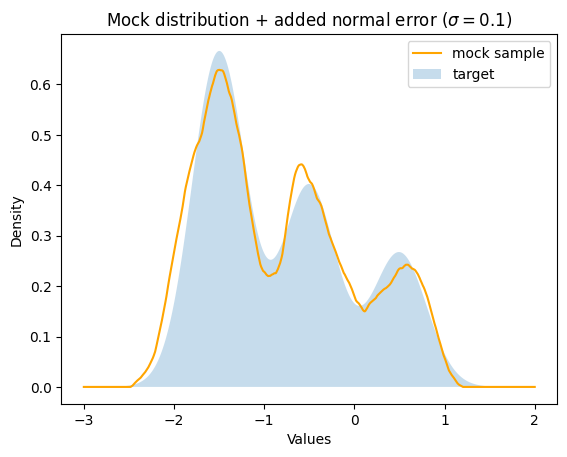

In [3]:
# Defining parameters of each Gaussian for mock set
mu1, sig1, p1 = -1.5, 0.3, 0.5
mu2, sig2, p2 = -0.5, 0.3, 0.3
mu3, sig3, p3 = 0.5, 0.3, 0.2

mus = np.array([mu1,mu2,mu3])
sigmas = np.array([sig1,sig2,sig3])
weights = np.array([p1,p2,p3])

# Points for function definition and plotting
xx = np.linspace(-3, 2, 1000)

# Sum error functions to generate cumulative distribution function (CDF)
Px = np.zeros_like(xx)
for mu, sig, weight in zip(mus, sigmas, weights):
    Px += weight * (1.+special.erf((xx-mu)/sig/np.sqrt(2.)))/2.

# Invert CDF 
inverse_cdf = interpolate.UnivariateSpline(Px, xx, s=0)

# Set seed for consistent random sample
np.random.seed(5658)

# Sample
N = 200
random_unif = np.random.random(N)

# Apply inverse CDF + random Gaussian error to emulate the distribution function
data = inverse_cdf(random_unif) + np.random.normal(0, 0.1, N)

# Calculate model distribution
yy_model = np.zeros(len(xx))
for k in range(len(mus)):
    yy_model += weights[k]*pdf_gauss(xx,mus[k],sigmas[k])

plt.plot(xx, kde(data, xx), color='orange', label='mock sample')
plt.fill(xx, yy_model, alpha=0.25, label='target')
plt.title('Mock distribution + added normal error ($\sigma=0.1$)')
plt.xlabel('Values')
plt.ylabel('Density')
plt.legend()
plt.show();

* In the above cell
    * the target parameters are defined
    * the error functions for each mode of the target distribution are summed to generate a CDF
    * the CDF is inverted and applied to a random sample of length N, with an added normally distributed error with $\mu=0$ and $\sigma=0.1$ 
    * the model distribution is directly calculated for comparison



* The plot shows the Epanechnikov KDE of the mock sample drawn from the target distribution, as well as the target itself.

2. Run Gaussian Mixture for this sample with different numbers of modes $K$ and determine the best value of $K$ according to either the AIC and BIC criteria.<br>

In [4]:
# Import SciKit's GMM implementation 
import sklearn
#print(sklearn.__version__)
from sklearn.mixture import GaussianMixture

# To avoid warnings from GMM
import os
os.environ["OMP_NUM_THREADS"] = "1"
import warnings
warnings.filterwarnings('ignore')


# GaussianMixture requires a 2D array as input
Data = data.reshape(-1,1) 

# Range of values for potential number of modes K
K = np.arange(1, 6)

# Intitialize empty list for different mode models
models = [None for n in K]

# Gaussian Mixture for each potential mode
for i in range(len(K)):
    models[i] = GaussianMixture(K[i], tol=1e-9, covariance_type='full').fit(Data) ########## since using prewritten version of GM, make sure to describe decisions for each input ############

# Calculate BIC for each K-mode model
AIC = [m.aic(Data) for m in models]
BIC = [m.bic(Data) for m in models]
#logL = [m.score(Data) for m in models]

# Choose the model that minimizes BIC
i_best = np.argmin(BIC)
gmm_best = models[i_best]

# Save parameters from gmm_best
gmm_best_means = gmm_best.means_.flatten()
gmm_best_sigs = np.sqrt(gmm_best.covariances_.flatten())
gmm_best_pk = gmm_best.weights_.flatten()

# Print results
print('K-modes:')
for i in range(len(K)):
    print(' K = %d    BIC = %.1f    AIC = %.1f'%(K[i], BIC[i], AIC[i]))
print()
print(f'GMM best parameters (K={len(gmm_best_means)}):')
print('mu =', gmm_best_means)
print('sig =', gmm_best_sigs)
print('pk =', gmm_best_pk)

K-modes:
 K = 1    BIC = 505.7    AIC = 499.2
 K = 2    BIC = 471.2    AIC = 454.7
 K = 3    BIC = 466.2    AIC = 439.8
 K = 4    BIC = 479.6    AIC = 443.4
 K = 5    BIC = 490.3    AIC = 444.1

GMM best parameters (K=3):
mu = [-1.53863625 -0.47211256  0.51804674]
sig = [0.29878929 0.27113891 0.2470159 ]
pk = [0.51470926 0.30979755 0.17549319]


* The Bayesian Information Criterion (BIC) & Akaike Information Criterion (AIC) are minimized with $K=3$ modes.

3. Plot the best-fitting model along with the histogram of the generated sample and the original distribution function. Use adaptive KDE histogram.<br>

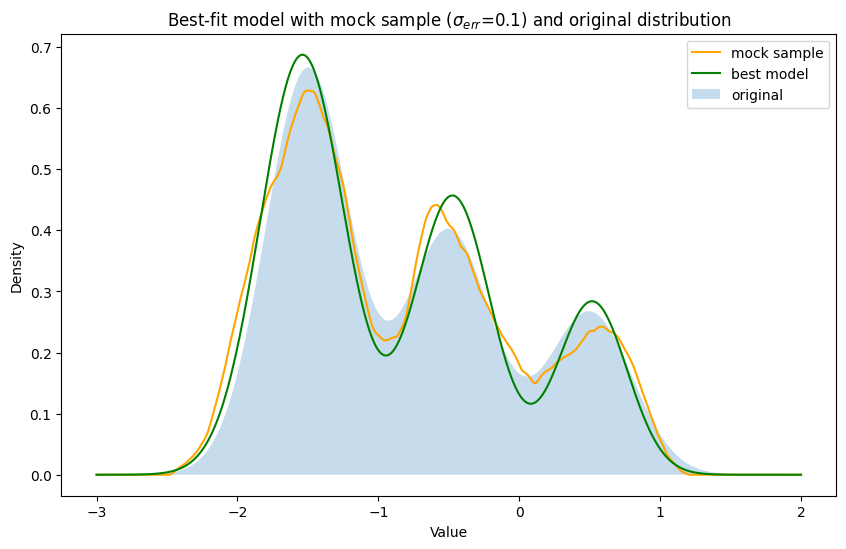

In [5]:
plt.figure(figsize=(10,6))

plt.plot(xx, kde(data, xx), c='orange', label='mock sample')

yy = np.zeros(len(xx))
for k in range(len(gmm_best_means)):
    yy += gmm_best_pk[k]*pdf_gauss(xx,gmm_best_means[k],gmm_best_sigs[k])



plt.plot(xx, yy, c='g', label='best model')
plt.fill(xx, yy_model, alpha=0.25, label='original')
plt.title('Best-fit model with mock sample ($\sigma_{err}$=0.1) and original distribution')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()

4. Compare the recovered values of the parameters with the original ones and comment on the accuracy of the method. Which parameters are recovered best? Parameters of which of the three modes are recovered best?<br>

In [6]:
# Display target parameters
print(f'Target parameters:')
print('mu =', mus)
print('sig=', sigmas)
print('pk =', weights)
print()


# Display recovered parameters
print(f'GMM best parameters [1st mode  2nd mode  3rd mode]:')
print('mu =', gmm_best_means)
print('sig=', gmm_best_sigs)
print('pk =', gmm_best_pk)
print()

# Differences
delta_mu = np.array(gmm_best_means) - np.array(mus)
delta_sig = np.array(gmm_best_sigs) - np.array(sigmas)
delta_pk = np.array(gmm_best_pk) - np.array(weights)
# Display
print(f'Absolute differences in recovered with target parameters for each mode:')
print('\u0394mu =', abs(delta_mu))
print('\u0394sig=', abs(delta_sig))
print('\u0394pk =', abs(delta_pk))

Target parameters:
mu = [-1.5 -0.5  0.5]
sig= [0.3 0.3 0.3]
pk = [0.5 0.3 0.2]

GMM best parameters [1st mode  2nd mode  3rd mode]:
mu = [-1.53863625 -0.47211256  0.51804674]
sig= [0.29878929 0.27113891 0.2470159 ]
pk = [0.51470926 0.30979755 0.17549319]

Absolute differences in recovered with target parameters for each mode:
Δmu = [0.03863625 0.02788744 0.01804674]
Δsig= [0.00121071 0.02886109 0.0529841 ]
Δpk = [0.01470926 0.00979755 0.02450681]


* Above are the best recovered parameters from GMM, the target parameters, and the differences between the two.
* The mean difference is the smallest for the 3rd mode, the SD difference is the smallest for the 1st mode, and the weight difference is smallest for the 2nd mode.
* Overall the parameters for the 2nd mode are recovered best

5. Generate another sample in a similar way, but with the standard deviation of the added error of 0.2. Comment on the difference in the recovered parameters with the first sample. How does the increased noise affect the reconstruction?

In [7]:
# Redefine inverse CDF with SD of added error = 0.2
data2 = inverse_cdf(random_unif) + np.random.normal(0, 0.2, N)

##### GMM for new set #####
Data2 = data2.reshape(-1,1) 
K = np.arange(1, 6)
models2 = [None for n in K]

for i in range(len(K)):
    models2[i] = GaussianMixture(K[i], tol=1e-9, covariance_type='full').fit(Data2)

AIC2 = [m.aic(Data2) for m in models2]
BIC2 = [m.bic(Data2) for m in models2]
i_best2 = np.argmin(BIC2)

gmm_best2 = models2[2]
gmm_best_means2 = gmm_best2.means_.flatten()
gmm_best_sigs2 = np.sqrt(gmm_best2.covariances_.flatten())
gmm_best_pk2 = gmm_best2.weights_.flatten()

# Print results
print('K-modes:')
for i in range(len(K)):
    print(' K = %d    BIC = %.1f    AIC = %.1f'%(K[i], BIC2[i], AIC2[i]))
print()
print('GMM best parameters (SD=0.2, K=3):')
print('mu =', gmm_best_means2)
print('sig =', gmm_best_sigs2)
print('pk =', gmm_best_pk2)
print()

# Compare with first set of recovered parameters
print(f'1st GMM best parameters (SD=0.1 on added error):')
print('mu =', gmm_best_means)
print('sig =', gmm_best_sigs)
print('pk =', gmm_best_pk)
print()

# Differences
delta_mu2 = np.array(gmm_best_means2) - np.array(mus)
delta_sig2 = np.array(gmm_best_sigs2) - np.array(sigmas)
delta_pk2 = np.array(gmm_best_pk2) - np.array(weights)
# Display
print(f'Absolute differences in SD=0.2 recovered parameters with SD=0.1 for each mode:')
print('\u0394mu =', abs(delta_mu2))
print('\u0394sig =', abs(delta_sig2))
print('\u0394pk =', abs(delta_pk2))

K-modes:
 K = 1    BIC = 520.3    AIC = 513.7
 K = 2    BIC = 499.8    AIC = 483.3
 K = 3    BIC = 510.1    AIC = 483.8
 K = 4    BIC = 525.7    AIC = 489.5
 K = 5    BIC = 540.4    AIC = 494.2

GMM best parameters (SD=0.2, K=3):
mu = [-1.5601257   0.42505928 -0.50657567]
sig = [0.33995207 0.3877014  0.30031677]
pk = [0.48945545 0.21677942 0.29376512]

1st GMM best parameters (SD=0.1 on added error):
mu = [-1.53863625 -0.47211256  0.51804674]
sig = [0.29878929 0.27113891 0.2470159 ]
pk = [0.51470926 0.30979755 0.17549319]

Absolute differences in SD=0.2 recovered parameters with SD=0.1 for each mode:
Δmu = [0.0601257  0.92505928 1.00657567]
Δsig = [0.03995207 0.0877014  0.00031677]
Δpk = [0.01054455 0.08322058 0.09376512]


* The differences between the recovered parameters from GMM for each of the samples with $\sigma=0.1$ and $0.2$ are on the order of the values of the parameters themselves.
* The recovered parameters from the $\sigma=0.1$ population are much closer to the target parameters than the $\sigma=0.2$, implying the added error affected the reconstruction negatively.
* Additionally, the BIC was actually minimized with $K=2$ modes, and since we know that the target distribution has three modes, the method has broken down at this point. The AIC was still minimized with $K=3$ modes, however.

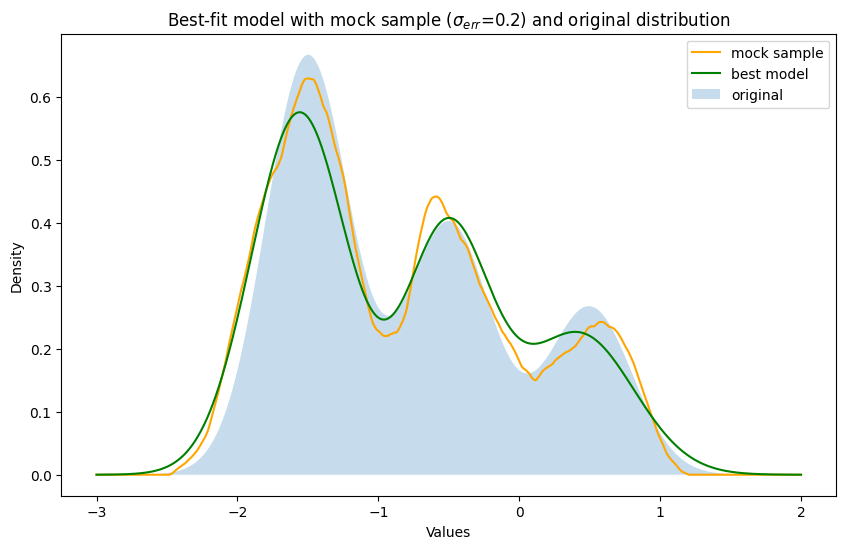

In [8]:
# Plot results from 2nd GMM
plt.figure(figsize=(10,6))

plt.plot(xx, kde(data, xx), c='orange', label='mock sample')

yy2 = np.zeros(len(xx))
for k in range(len(gmm_best_means)):
    yy2 += gmm_best_pk2[k]*pdf_gauss(xx,gmm_best_means2[k],gmm_best_sigs2[k])

plt.plot(xx, yy2, c='g', label='best model')
plt.fill(xx, yy_model, alpha=0.25, label='original')
plt.title('Best-fit model with mock sample ($\sigma_{err}$=0.2) and original distribution')
plt.xlabel('Values')
plt.ylabel('Density')
plt.legend()
plt.show()

## Analysis
* Which numerical methods worked or did not work in this project
    * The transformation method worked to generate a mock data set of $N=200$ random variables $x$ drawn from the given distribution function with random, normally distributed added errors.
    * The Bayesian Information Criterion (BIC) worked to determine the optimal number of modes for Gaussian Mixture Modeling reconstruction of the target distribution function.
* Lessons learned
    * The purpose of each individual step of the transformation method for mock data sampling is much clearer to me.
    * Working with and manipulating the GMM implementations got me more comfortable with the process with things like why we minimize the BIC for mode optimization, etc.
    * The concept of a sum of Gaussians was still new to me before this section of the course, so working with and generating this type of distribution was enlightening.
* Further code improvements you could make with significantly more effort
    * I would've liked to mess with all of the inputs (e.g. N samples, the parameters of each mode of the target, the amount of noise added, etc.) to see how the reconstruction is altered.
    * I would've liked to research additional information criteria and compare their results with the AIC and BIC used.
